In [95]:
# Check if we're using GPU
!nvidia-smi

Thu Oct 12 23:20:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    31W /  70W |   1857MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [96]:
# Get data (10% of food classes from Food101)
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


--2023-10-12 23:20:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.207, 74.125.20.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   201MB/s    in 0.8s    

2023-10-12 23:20:06 (201 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [97]:
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [98]:
# How many images in each folde?
import os

# Walk through 1- percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in `{dirpath}`")

There are 2 directories and 0 images in `10_food_classes_10_percent`
There are 10 directories and 0 images in `10_food_classes_10_percent/test`
There are 0 directories and 250 images in `10_food_classes_10_percent/test/grilled_salmon`
There are 0 directories and 250 images in `10_food_classes_10_percent/test/steak`
There are 0 directories and 250 images in `10_food_classes_10_percent/test/hamburger`
There are 0 directories and 250 images in `10_food_classes_10_percent/test/fried_rice`
There are 0 directories and 250 images in `10_food_classes_10_percent/test/chicken_curry`
There are 0 directories and 250 images in `10_food_classes_10_percent/test/chicken_wings`
There are 0 directories and 250 images in `10_food_classes_10_percent/test/ramen`
There are 0 directories and 250 images in `10_food_classes_10_percent/test/sushi`
There are 0 directories and 250 images in `10_food_classes_10_percent/test/ice_cream`
There are 0 directories and 250 images in `10_food_classes_10_percent/test/pizza

In [99]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [100]:
import tensorflow as tf
IMG_SIZE=(224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [101]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [102]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating a ModelCheckpoint callback

In [103]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoint_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

## Model 0: Building a transfer leanring feature extraction model using the keras Functional API

In [105]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model(aggregate all the most important
#     information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=10,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_feature_extraction"),
                                   checkpoint_callback])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20231012-232145
Epoch 1/10
23/24 [===========================>..] - ETA: 0s - loss: 1.8547 - accuracy: 0.4443
Epoch 1: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 14s 271ms/step - loss: 1.8432 - accuracy: 0.4520 - val_loss: 1.2322 - val_accuracy: 0.7566
Epoch 2/10
23/24 [===========================>..] - ETA: 0s - loss: 1.0885 - accuracy: 0.7704
Epoch 2: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 4s 158ms/step - loss: 1.0847 - accuracy: 0.7693 - val_loss: 0.8396 - val_accuracy: 0.8224
Epoch 3/10
23/24 [===========================>..] - ETA: 0s - loss: 0.7872 - accuracy: 0.8342
Epoch 3: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==

In [106]:
results_10_percent_data = model_0.evaluate(test_data)
results_10_percent_data

79/79 [==============================] - 6s 77ms/step - loss: 0.4366 - accuracy: 0.8756


[0.43663519620895386, 0.8755999803543091]

In [107]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_12
1 rescaling_22
2 normalization_11
3 rescaling_23
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_acti

In [108]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_22 (Rescaling)    (None, None, None, 3)        0         ['input_12[0][0]']            
                                                                                                  
 normalization_11 (Normaliz  (None, None, None, 3)        7         ['rescaling_22[0][0]']        
 ation)                                                                                           
                                                                                                  
 rescaling_23 (Rescaling)    (None, None, None, 3)        0         ['normalization_1

In [109]:
# How about a summary of our whole model?
model_0.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
________________

In [110]:
# Let's create a function to plot our loss curves..
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs= range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

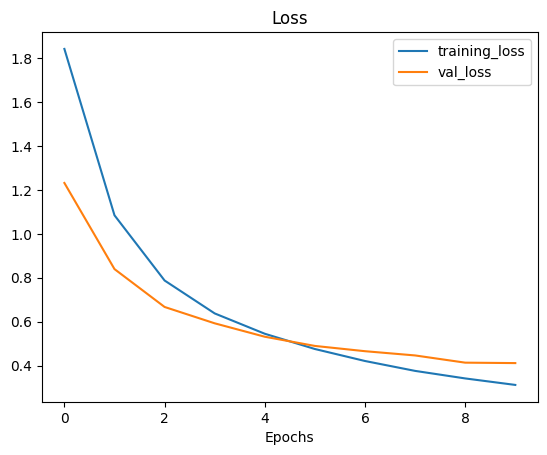

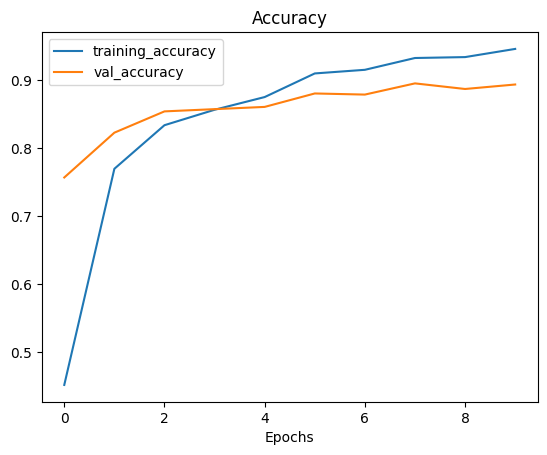

In [111]:
plot_loss_curves(history_0)

## Loading in checkpointed weights

Loading in checkpointed weight returns a model to a specific checkpoint

In [112]:
# Load in saved model weights and evaluate model
model_0.load_weights(checkpoint_path)

In [113]:
# Evaluate model_0 with loaded weights
loaded_weights_model_results = model_0.evaluate(test_data)

79/79 [==============================] - 7s 86ms/step - loss: 0.4366 - accuracy: 0.8756


In [114]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data), np.array(loaded_weights_model_results))

array([ True,  True])

## Fine-tunning an existing model on 10% of the data


In [115]:
# Layers in loaded model
model_0.layers

In [116]:
# Are these layers trainable?
for layer in model_0.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7b250fc0dde0> True
<keras.src.engine.functional.Functional object at 0x7b23ac3bc7f0> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7b23ac3be590> True
<keras.src.layers.core.dense.Dense object at 0x7b23ac2608b0> True


In [117]:
# What layers are in our base_model (efficientnetB0) and are they trainable?
for i, layer in enumerate(model_0.layers[1].layers):
  print(i, layer.name, layer.trainable)

0 input_12 False
1 rescaling_22 False
2 normalization_11 False
3 rescaling_23 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze 

In [118]:
# How many trainable variables are in our base model?
print(len(model_0.layers[1].trainable_variables))

0


In [119]:
# To begin fine-tuning, let's start by setting the last 20 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 20
for layer in base_model.layers[:-20]:
  layer.trainable=False

In [120]:
# Recompile (we have to recompile our models every time we make a change)
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [121]:
# Check wich layer are tunable (trainable)
for layer_number, layer in enumerate(model_0.layers[1].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_12 False
1 rescaling_22 False
2 normalization_11 False
3 rescaling_23 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze 

In [122]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_0.trainable_variables))

21


In [123]:
# Fine tune for another 10 epochs
fine_tune_epochs = 20

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data = model_0.fit(train_data_10_percent,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_0.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_fine_tune_last_20"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_20/20231012-232319
Epoch 10/20
23/24 [===========================>..] - ETA: 0s - loss: 0.7610 - accuracy: 0.8193
Epoch 10: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 17s 234ms/step - loss: 0.7603 - accuracy: 0.8187 - val_loss: 0.3860 - val_accuracy: 0.8947
Epoch 11/20
23/24 [===========================>..] - ETA: 0s - loss: 0.4817 - accuracy: 0.9253
Epoch 11: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 6s 226ms/step - loss: 0.4892 - accuracy: 0.9213 - val_loss: 0.3678 - val_accuracy: 0.8898
Epoch 12/20
23/24 [===========================>..] - ETA: 0s - loss: 0.3517 - accuracy: 0.9552
Epoch 12: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 8s 319ms/step - loss: 0.3532 - accuracy: 0.9533 - val_loss: 0.3702 - val_accur

In [124]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow history objects.
  """
  # Get original historymeasurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

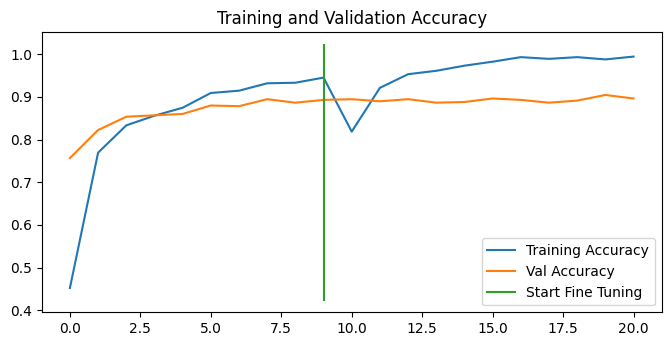

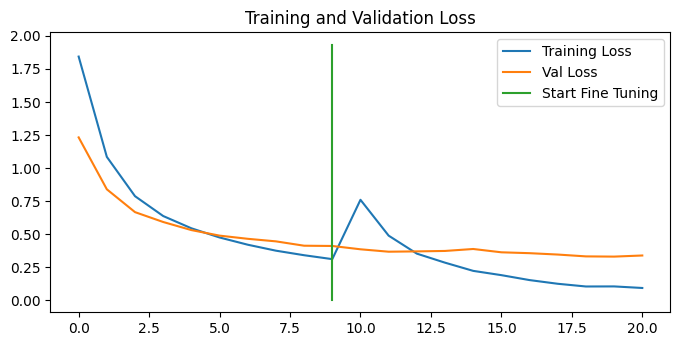

In [125]:
compare_historys(history_0,
                 history_fine_10_percent_data,
                 initial_epochs=10)

In [126]:
class_names = test_data.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [127]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/no
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img  # don't need to rescale images for EfficientNet models in TensorFlow

10_food_classes_10_percent/test/ramen/3553271.jpg
1/1 [==============================] - 2s 2s/step
10_food_classes_10_percent/test/ramen/560626.jpg
1/1 [==============================] - 0s 31ms/step
10_food_classes_10_percent/test/hamburger/2884546.jpg
1/1 [==============================] - 0s 29ms/step


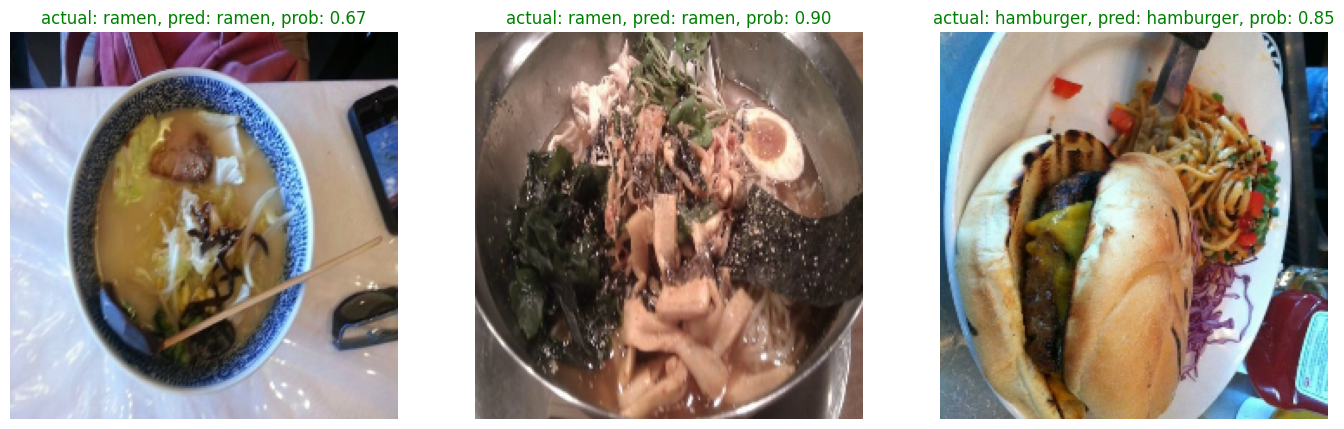

In [128]:
# Make preds on a series of random images
import os
import random
plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image(s) from random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
  print(filepath)

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = model_0.predict(img_expanded)      # get predictions probabilities array
  pred_class = class_names[pred_prob.argmax()]  # get highest prediction probability index and match it class_names list
  # print(pred_prob)
  # print(pred_class)

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [129]:
# To begin fine-tuning, let's continue by setting the last 30 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 20
for layer in base_model.layers[:-30]:
  layer.trainable=False

In [130]:
# Recompile (we have to recompile our models every time we make a change)
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                metrics=["accuracy"])

In [131]:
# Check wich layer are tunable (trainable)
for layer_number, layer in enumerate(model_0.layers[1].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_12 False
1 rescaling_22 False
2 normalization_11 False
3 rescaling_23 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze 

In [132]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_0.trainable_variables))

30


In [133]:
# Fine tune for another 10 epochs
fine_tune_epochs = 30

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_30 = model_0.fit(train_data_10_percent,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_fine_10_percent_data.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_fine_tune_last_20"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_20/20231012-232439
Epoch 20/30
23/24 [===========================>..] - ETA: 0s - loss: 0.0959 - accuracy: 0.9946
Epoch 20: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 18s 252ms/step - loss: 0.0954 - accuracy: 0.9947 - val_loss: 0.3410 - val_accuracy: 0.8980
Epoch 21/30
23/24 [===========================>..] - ETA: 0s - loss: 0.0955 - accuracy: 0.9946
Epoch 21: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 5s 208ms/step - loss: 0.0960 - accuracy: 0.9947 - val_loss: 0.3247 - val_accuracy: 0.9112
Epoch 22/30
23/24 [===========================>..] - ETA: 0s - loss: 0.1001 - accuracy: 0.9946
Epoch 22: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 5s 210ms/step - loss: 0.1008 - accuracy: 0.9947 - val_loss: 0.3399 - val_accur

In [141]:
def compare_3_historys(original_history, second_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow history objects.
  """
  # Get original historymeasurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # second historymeasurements
  first_total_acc = acc + second_history.history["accuracy"]
  first_total_loss = loss + second_history.history["loss"]

  first_total_val_acc = val_acc + second_history.history["val_accuracy"]
  first_total_val_loss = val_loss + second_history.history["val_loss"]

  # Combine original history metrics with new_history metrics
  total_acc = first_total_acc + new_history.history["accuracy"]
  total_loss = first_total_loss + new_history.history["loss"]

  total_val_acc = first_total_val_acc + new_history.history["val_accuracy"]
  total_val_loss = first_total_val_loss + new_history.history["val_loss"]

  # Make plots for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

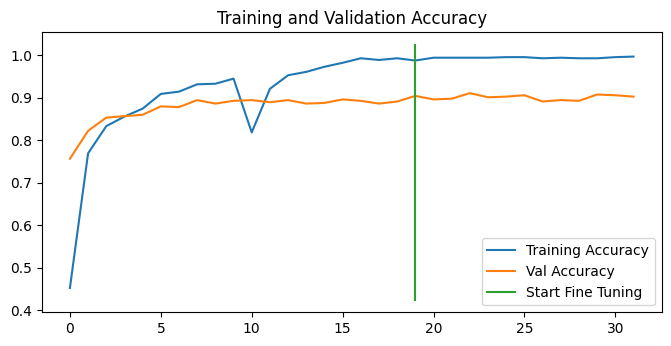

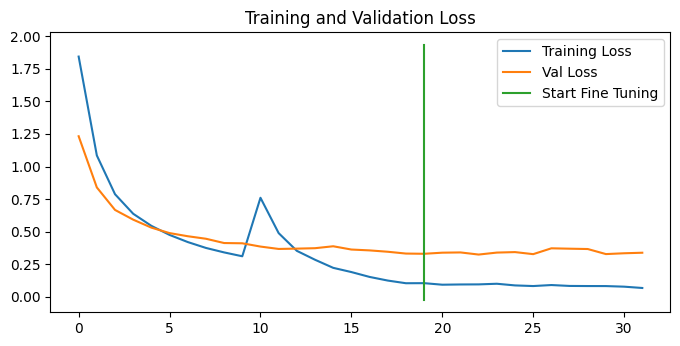

In [142]:
compare_3_historys(original_history=history_0,
                   second_history=history_fine_10_percent_data,
                 new_history=history_fine_10_percent_data_30,
                 initial_epochs=20)

In [139]:
history_fine_10_percent_data_30.history["accuracy"]

[0.9946666955947876,
 0.9946666955947876,
 0.9946666955947876,
 0.9959999918937683,
 0.9959999918937683,
 0.9933333396911621,
 0.9946666955947876,
 0.9933333396911621,
 0.9933333396911621,
 0.9959999918937683,
 0.9973333477973938]